# Peparacion del data frame

## Configuración inicial y carga de datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

Cargar archivo

In [21]:
import csv

with open('Anexo ET_demo_round_traces_2022.csv') as csvfile:
    df = pd.read_csv(csvfile, sep=";")

Limpiar nulos

In [22]:
df.dropna(how='any', inplace=True)
null_values_new = df.isnull().sum()
print(null_values_new[null_values_new > 0])

Series([], dtype: int64)


Quitar variables con las que no se van a usar en el modelo

In [23]:
#droped_vars = ("AbnormalMatch","TravelledDistance","Map","InternalTeamId","MatchId",
#               "RoundId","RoundWinner","Survived","RLethalGrenadesThrown","RNonLethalGrenadesThrown",
#               "PrimaryAssaultRifle","PrimarySniperRifle","PrimaryHeavy","PrimarySMG","PrimaryPistol",
#               "RoundAssists","RoundHeadshots","RoundFlankKills","MatchFlankKills","MatchAssists","MatchHeadshots",
#               "MatchKills","Unnamed: 0")

droped_vars = ("AbnormalMatch", "Unnamed: 0","TravelledDistance","MatchId","InternalTeamId","RoundId")

for var in droped_vars:
  df = df.drop(var, axis=1)


transformar objeto a int

In [24]:
# Transformar variables Objecto a int
try:
  df['TimeAlive'] = pd.to_numeric(df['TimeAlive'].str.replace('.', ''))
  df['FirstKillTime'] = pd.to_numeric(df['FirstKillTime'].str.replace('.', ''))
except Exception as e:
  print(f'{e}\n')


Transformar las variables categoricas Team y MatchWinner a binario.

Team:
* Terrorist: 0
* CounterTerrorist: 1

MatchWinner:
* True: 1
* False: 0

RoundWinner:
* True: 1
* False: 0

In [25]:
df.Team.replace(to_replace=['Terrorist', 'CounterTerrorist'], value=[0, 1], inplace=True )
df.MatchWinner.replace(to_replace=['False', 'True'], value=[0, 1], inplace=True )
df.RoundWinner.replace(to_replace=['False', 'True'], value=[0, 1], inplace=True )

for var in ("Team", "MatchWinner","RoundWinner"):
    df[var] = df[var].astype(int)

Map:
* de_inferno: 0
* de_nuke: 1
* de_mirage: 2 
* de_dust2: 3

In [26]:
df.Map.replace(to_replace=['de_inferno', 'de_nuke','de_mirage','de_dust2'], 
               value=list(range(0,4)), 
               inplace=True )

df['Map'] = df['Map'].astype(int)


In [27]:
df.head()

,Map,Team,RoundWinner,MatchWinner,Survived,TimeAlive,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryAssaultRifle,PrimarySniperRifle,PrimaryHeavy,PrimarySMG,PrimaryPistol,FirstKillTime,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,0,0,0,1,False,51120248995704500,0,4,0.0,0.0,0.0,0.0,1,0,0,0,0,0,750,4400,0,0,0,0
1,0,0,0,1,False,4348662552266170,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,800,4400,0,0,0,0
2,0,0,0,1,False,3735469847054540,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1000,4400,0,0,0,0
3,0,0,0,1,False,4767886136441470,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,850,4400,0,0,0,0
4,0,0,0,1,True,5312251089027310,1,1,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1000,4400,0,0,0,0


## Objetivo

Utilizar las variables para determinar el tiempo de vida (TimeAlive) del jugador

In [28]:
import sklearn.metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

In [ ]:
goal = "MatchWinner"

x = df.drop(goal,axis=1)
y = df[goal]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(x,y,test_size=0.2)

In [31]:
model = DecisionTreeClassifier()

import math

params_features = np.arange(
                math.trunc(len(df.columns)/3),
                len(df.columns)
                )

params = {"max_depth": np.arange(1,20,2),
          "min_samples_split": np.arange(10,20,2),
          "max_features": params_features
          }

grid = GridSearchCV(estimator=model, param_grid=params,cv=10)
grid.fit(Xtrain, Ytrain)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_features': array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
                         'min_samples_split': array([10, 12, 14, 16, 18])})

In [32]:
print(grid.best_score_)
print(grid.best_params_)

0.6609603617466052
{'max_depth': np.int64(11), 'max_features': np.int64(20), 'min_samples_split': np.int64(10)}


In [33]:
best_estimator = grid.best_estimator_

In [34]:
Yhat = best_estimator.predict(Xtest)

ba = balanced_accuracy_score(Ytest, Yhat)
ap = average_precision_score(Ytest, Yhat)
f1 = f1_score(Ytest, Yhat)

print("accuracy: ",ba)
print("precision: ",ap)
print("f1: ",f1)

accuracy:  0.6579181415266361
precision:  0.577527529184158
f1:  0.628056806373398


In [42]:
features = best_estimator.feature_importances_
feature_names = best_estimator.feature_names_in_
print(pd.DataFrame(features, columns = ["Imp"], index =feature_names).sort_values(by = 'Imp', ascending = False))

                                  Imp
TeamStartingEquipmentValue   0.259509
RoundWinner                  0.218107
MatchKills                   0.135180
TimeAlive                    0.065083
FirstKillTime                0.054223
RoundStartingEquipmentValue  0.047094
MatchAssists                 0.044548
Map                          0.041087
Team                         0.023467
MatchHeadshots               0.022908
MatchFlankKills              0.017475
RNonLethalGrenadesThrown     0.012806
RLethalGrenadesThrown        0.012573
Survived                     0.008877
PrimarySniperRifle           0.005576
RoundHeadshots               0.005479
RoundKills                   0.005249
PrimaryAssaultRifle          0.005161
PrimarySMG                   0.004093
RoundFlankKills              0.003954
PrimaryPistol                0.003903
RoundAssists                 0.003181
PrimaryHeavy                 0.000466


Graficos

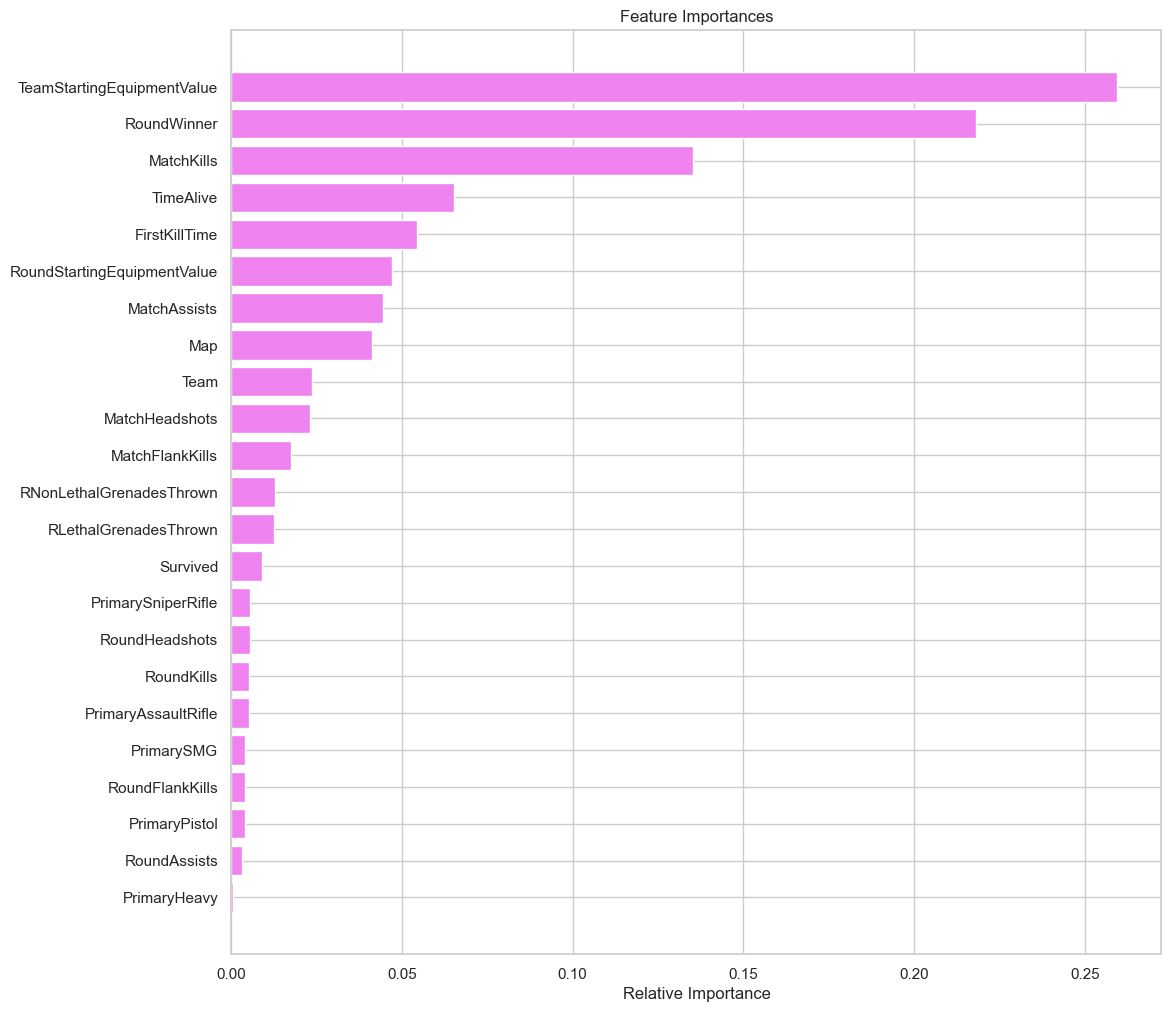

In [ ]:
# Plotting feature importances
indices = np.argsort(features)
 
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), features[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


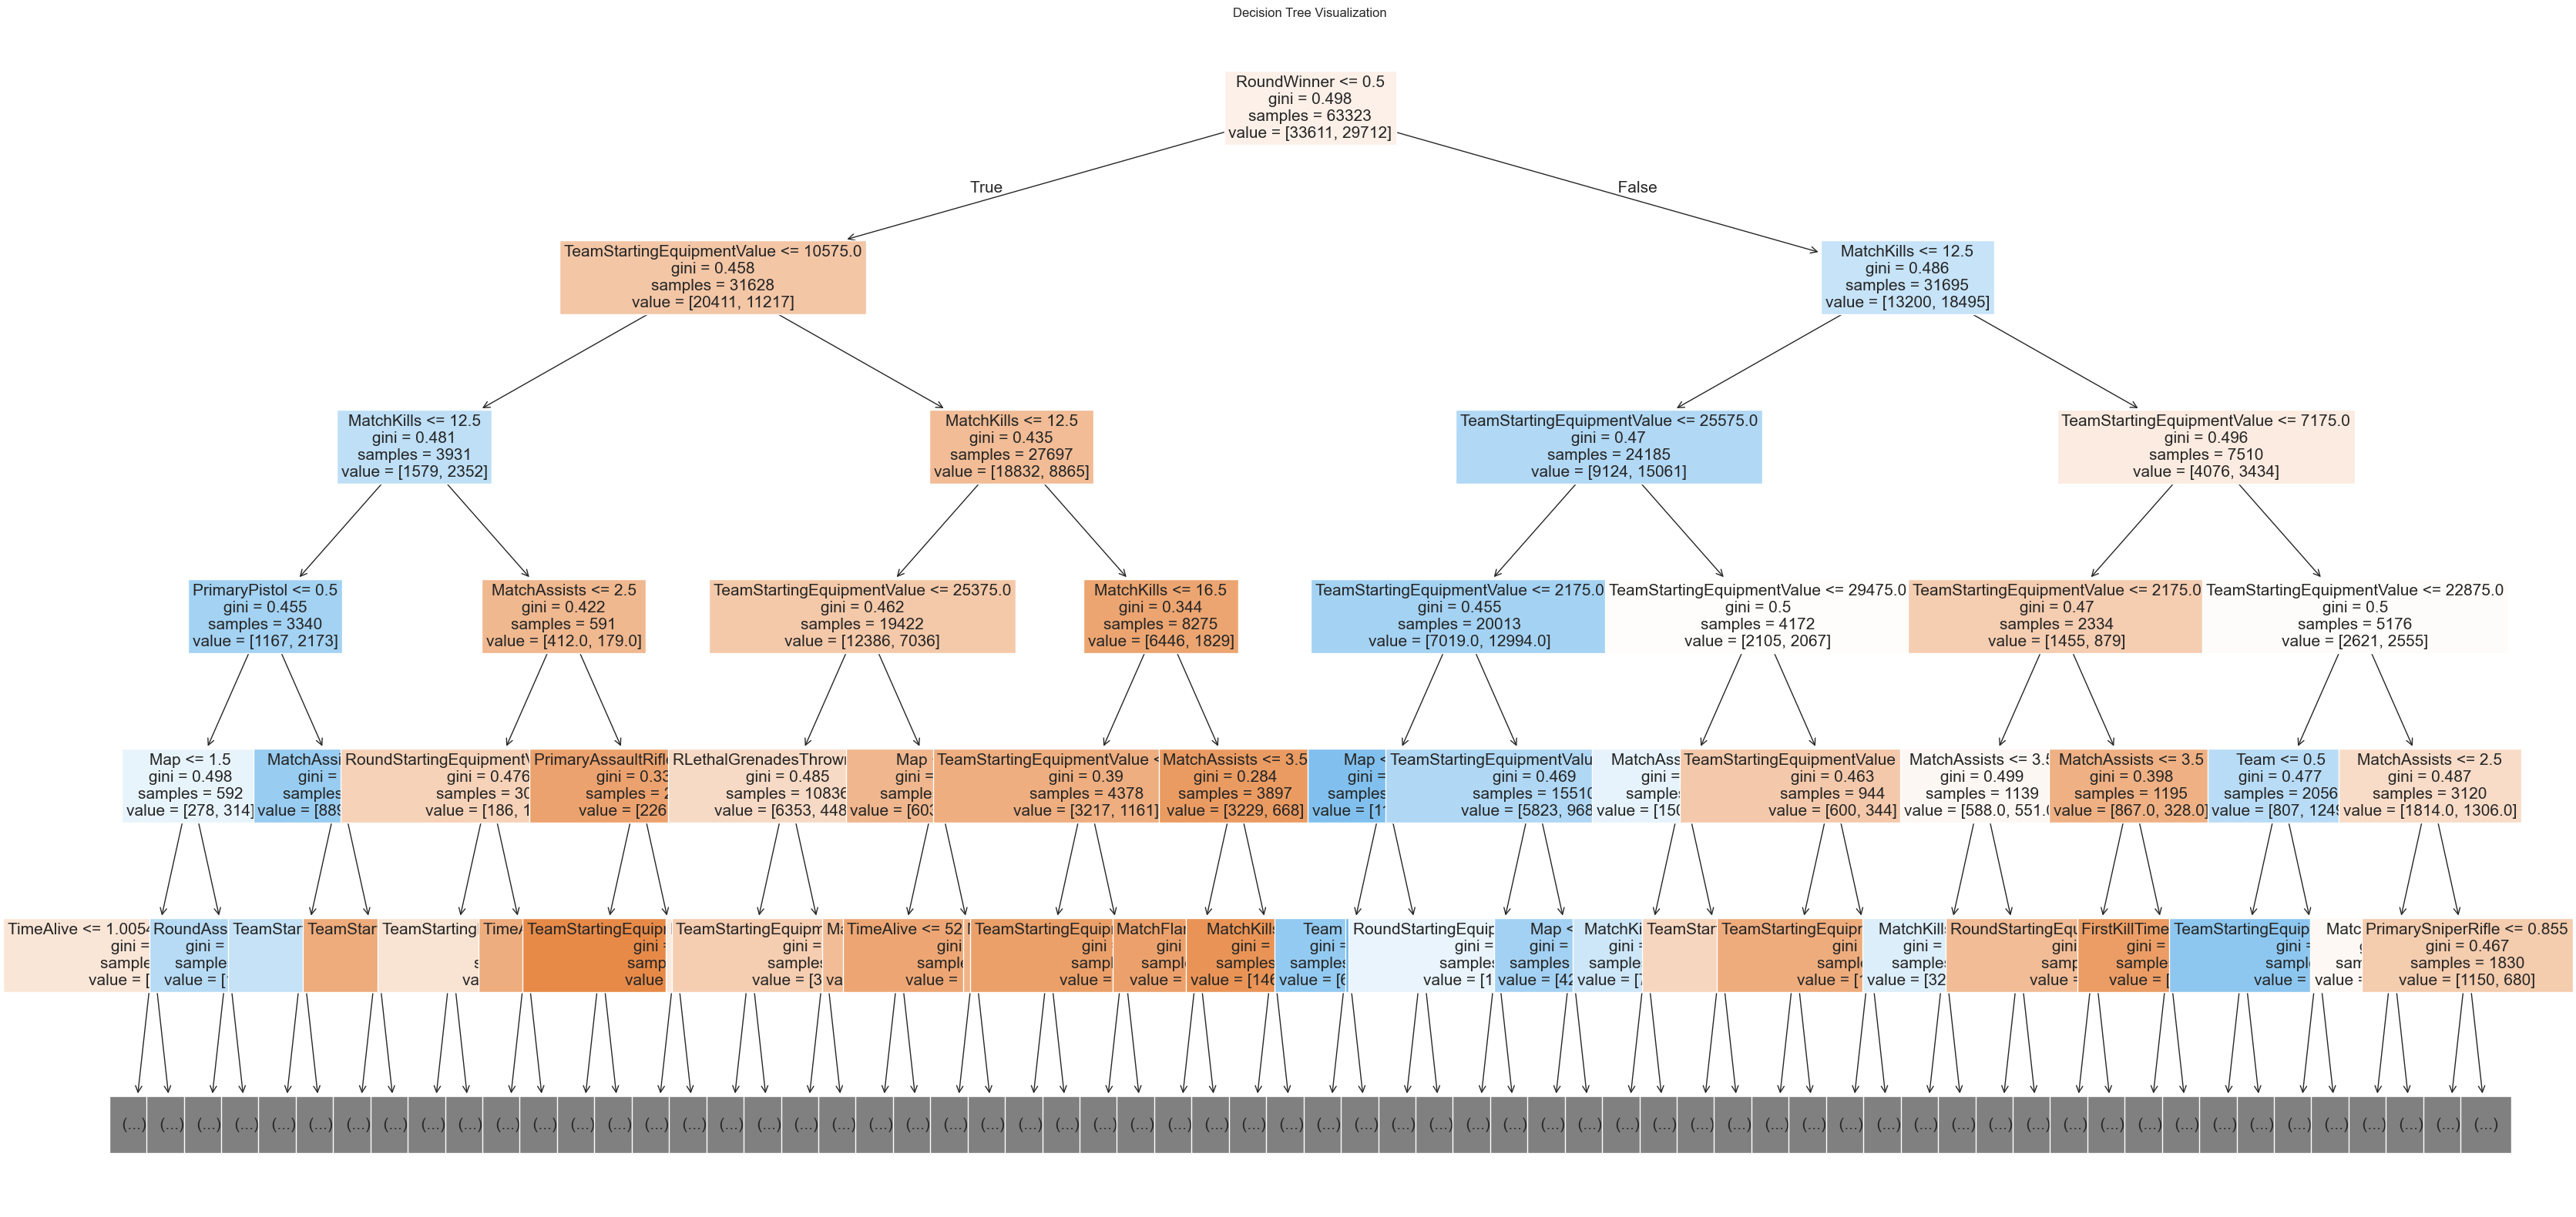

In [46]:
from sklearn.tree import plot_tree

plt.figure(figsize=(40, 20))
plot_tree(best_estimator, filled=True, 
          feature_names=feature_names,
          max_depth=5,fontsize=15)
plt.title('Decision Tree Visualization')
plt.show()